# Sources
[Original Paper](https://arxiv.org/abs/1708.05234) 

[Tensorflow Implementation](https://github.com/TropComplique/FaceBoxes-tensorflow)

[Dockerize Implementation](https://hub.docker.com/r/arrahm/faceboxes/)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# Needs tensorflow version 1.10 or greater 
print(tf.__version__)

1.10.1


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import numpy as np
from PIL import Image, ImageDraw
import os
import cv2
import time
import urllib
from urllib.request import urlopen
import matplotlib.pyplot as plt

# Face Detector

In [4]:
class FaceDetector:
    def __init__(self, model_path, gpu_memory_fraction=0.25, visible_device_list='0'):
        """
        Arguments:
            model_path: a string, path to a pb file.
            gpu_memory_fraction: a float number.
            visible_device_list: a string.
        """
        with tf.gfile.GFile(model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        graph = tf.Graph()
        with graph.as_default():
            tf.import_graph_def(graph_def, name='import')

        self.input_image = graph.get_tensor_by_name('import/image_tensor:0')
        self.output_ops = [
            graph.get_tensor_by_name('import/boxes:0'),
            graph.get_tensor_by_name('import/scores:0'),
            graph.get_tensor_by_name('import/num_boxes:0'),
        ]

        gpu_options = tf.GPUOptions(
            per_process_gpu_memory_fraction=gpu_memory_fraction,
            visible_device_list=visible_device_list
        )
        config_proto = tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False)
        self.sess = tf.Session(graph=graph, config=config_proto)

    def __call__(self, image, score_threshold=0.5):
        """Detect faces.
        Arguments:
            image: a numpy uint8 array with shape [height, width, 3],
                that represents a RGB image.
            score_threshold: a float number.
        Returns:
            boxes: a float numpy array of shape [num_faces, 4].
            scores: a float numpy array of shape [num_faces].
        Note that box coordinates are in the order: ymin, xmin, ymax, xmax!
        """
        h, w, _ = image.shape
        image = np.expand_dims(image, 0)

        boxes, scores, num_boxes = self.sess.run(
            self.output_ops, feed_dict={self.input_image: image}
        )
        num_boxes = num_boxes[0]
        boxes = boxes[0][:num_boxes]
        scores = scores[0][:num_boxes]

        to_keep = scores > score_threshold
        boxes = boxes[to_keep]
        scores = scores[to_keep]

        scaler = np.array([h, w, h, w], dtype='float32')
        boxes = boxes * scaler

        return boxes, scores

In [5]:
model_path = os.path.join('models', 'faceboxes_model.pb')
model_url = 'https://facialstorage.blob.core.windows.net/models/faceboxes_model.pb'
urllib.request.urlretrieve (model_url, model_path)
face_detector = FaceDetector(model_path, gpu_memory_fraction=0.25, visible_device_list='0')

# Get an image

In [6]:
def download_image(url):
    req = urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def resize_image(image_array):
    image = Image.fromarray(image_array)
    desired_size = 768
    old_size = image.size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int
                      (x * ratio) for x in old_size])
    image = image.resize(new_size, Image.ANTIALIAS)
    return image

In [7]:
image = download_image('https://i.amz.mshcdn.com/WZUyjzT0PDhqKpbcSAi4QYV-TWU=/950x534/filters:quality(90)/https%3A%2F%2Fblueprint-api-production.s3.amazonaws.com%2Fuploads%2Fcard%2Fimage%2F792479%2Fae396389-d75b-4852-9a8a-7b34e28f71bd.jpg')
# !!! Image should be at least 768 pixels wide to find faces properly 
image = resize_image(image)
image_array = np.array(image)

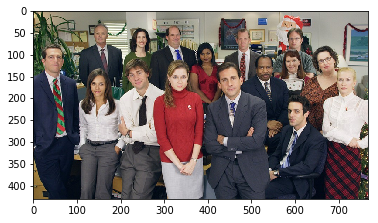

In [8]:
plt.imshow(image)

# Show detections

In [9]:
def draw_boxes_on_image(image, boxes, scores):
    print(image.size)
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy, 'RGBA')
    width, height = image.size

    for b, s in zip(boxes, scores):
        ymin, xmin, ymax, xmax = b
        fill = (255, 0, 0, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
        draw.text((xmin, ymin), text='{:.3f}'.format(s))
    return image_copy

(768, 431)


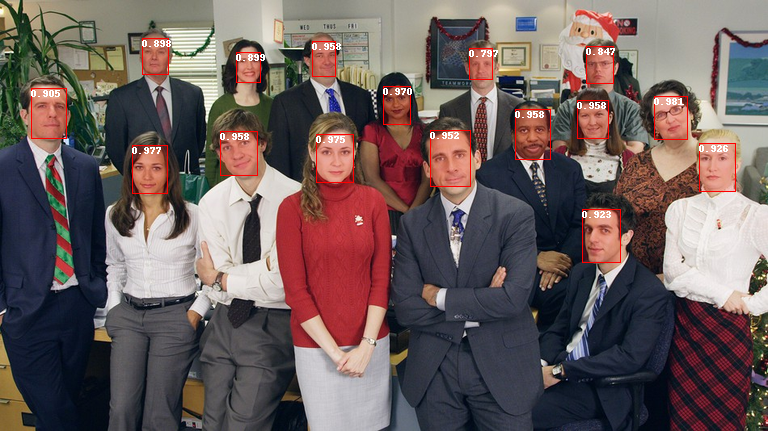

In [10]:
boxes, scores = face_detector(image_array, score_threshold=0.3)
draw_boxes_on_image(Image.fromarray(image_array), boxes, scores)

# Measure speed

In [16]:
times = []
for _ in range(110):
    start = time.perf_counter()
    boxes, scores = face_detector(image_array, score_threshold=0.25)
    times.append(time.perf_counter() - start)
    
times = np.array(times)
times = times[10:]
print('average time(sec):{}, std deviation: {}'.format(times.mean(), times.std()))

average time(sec):0.025305808419998358, std deviation: 0.0014581008719369262


# Using the Docker container

In [12]:
# Instructions and container are hosted here:
# https://hub.docker.com/r/arrahm/faceboxes/
import docker
import tempfile
import os
import io
import zlib
import base64

# Create a temporary file from image array so we can use it with the docker container
with tempfile.NamedTemporaryFile(mode="wb", dir=os.getcwd()) as image_file:
    f = io.BytesIO()
    image.save(image_file, 'png')
    image_name = os.path.basename(image_file.name)
    base_dir = os.path.dirname(image_file.name)
    command = '--image_path=/images/' + image_name
    volumes = {base_dir: {'bind': '/images', 'mode': 'ro'}}
    client = docker.from_env()
    stdout = client.containers.run('arrahm/faceboxes',
                                   command,
                                   volumes=volumes,
                                   auto_remove=True)
    json_obj = json.loads(stdout.decode('utf-8').strip())
    boxes = json_obj['boxes']
    scores = json_obj['scores']

(768, 431)


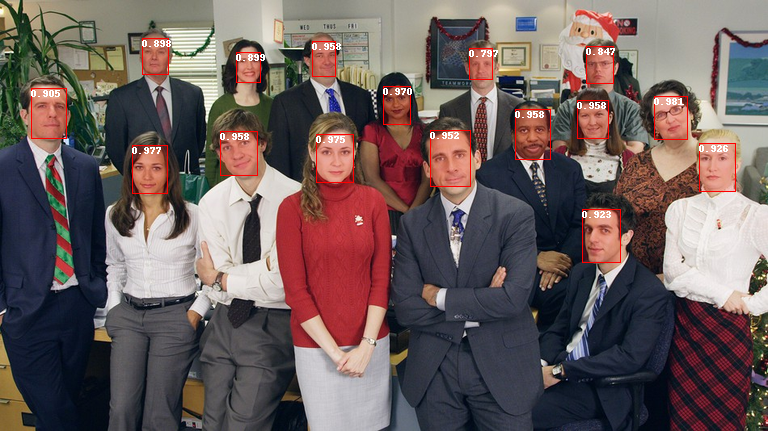

In [13]:
draw_boxes_on_image(Image.fromarray(image_array), boxes, scores)